# <center>支持向量机练习</center>

## 任务说明
在本部分中，你将：
- 实现**SVM 损失函数和梯度的计算**
- 使用**随机梯度下降 (SGD)** 来**优化**损失函数

In [1]:
import random
import os
import numpy as np
from fduml.utils import load_CIFAR10
import matplotlib.pyplot as plt

# 让 matplotlib 图表在 notebook 内显示，而不是在新窗口中打开。
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 让notebook能够重新加载外部的 Python 模块；
%load_ext autoreload
%autoreload 2

## CIFAR-10 数据集加载和预处理

In [2]:
# 加载数据集

cifar10_dir = 'datasets/cifar'
# 清理变量，防止多次加载
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 查看数据维度
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


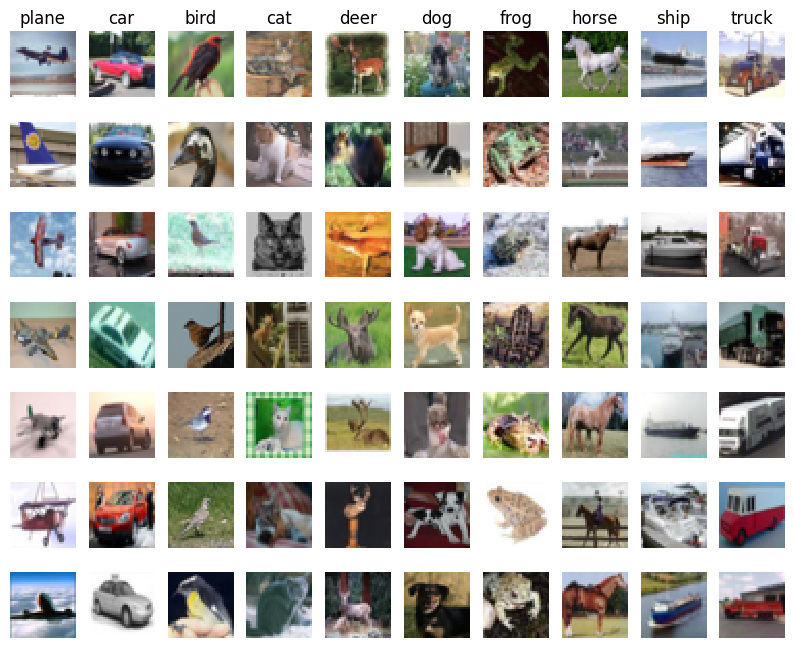

In [3]:
# 从数据集中可视化部分样本

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# 保存原始训练集，防止数据划分重复运行时报错
X_train_full = X_train.copy()
y_train_full = y_train.copy()

In [5]:
num_training = 49000
num_validation = 1000

num_test = 1000
num_dev = 4000

# 验证集
mask = range(num_training, num_training + num_validation)
X_val = X_train_full[mask]
y_val = y_train_full[mask]

# 训练集
mask = range(num_training)
X_train = X_train_full[mask]
y_train = y_train_full[mask]

# 开发集(从训练集中随机选择)
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# 测试集
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# 预处理，将图像数据变成向量
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (4000, 3072)


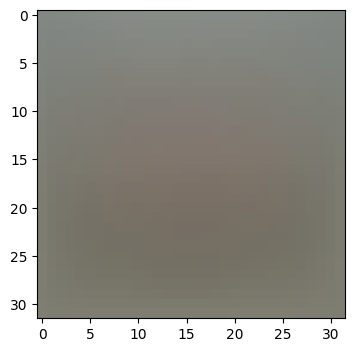

(49000, 3073) (1000, 3073) (1000, 3073) (4000, 3073)


In [7]:
# 预处理：数据中心化，添加偏置
# 第一，计算并可视化平均图像
mean_image = np.mean(X_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# 第二步：减去平均图像
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# 添加全为 1 的偏置维度，这样支持向量机（SVM）只需优化一个权重矩阵 W 即可。
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM 分类器

损失和梯度计算代码需要在linear_svm.py中完成

训练相关代码需要在linear_classifier.py中完成

In [8]:
from fduml.linear_svm import svm_loss_naive
import time

# 生成一个数值很小的随机 SVM 权重矩阵
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.260852


In [9]:
# 实现梯度计算后，用下面的代码计算，并使用提供的函数进行梯度检查
# 误差应该会在1e-2以内，大多数在1e-5以内

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

from fduml.utils import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# 在有正则化的情况下，重新检查
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -17.164738 analytic: -17.164738, relative error: 2.104837e-11
numerical: -21.734483 analytic: -21.734483, relative error: 8.854853e-11
numerical: 3.779786 analytic: 3.779786, relative error: 1.209117e-10
numerical: -12.472382 analytic: -12.473926, relative error: 6.187303e-05
numerical: 0.594736 analytic: 0.594736, relative error: 3.653812e-10
numerical: -3.213710 analytic: -3.213710, relative error: 1.860040e-10
numerical: -2.790682 analytic: -2.790682, relative error: 1.469749e-10
numerical: 23.314851 analytic: 23.314851, relative error: 1.316768e-11
numerical: -0.390305 analytic: -0.390305, relative error: 3.231010e-10
numerical: -20.596088 analytic: -20.596290, relative error: 4.899854e-06
numerical: 5.925871 analytic: 5.925871, relative error: 2.167673e-10
numerical: 9.240685 analytic: 9.240685, relative error: 2.549864e-12
numerical: 3.093201 analytic: 3.089032, relative error: 6.744036e-04
numerical: -23.885377 analytic: -23.885377, relative error: 1.217438e-13
numeri

In [10]:
# 接下来实现向量化的 svm 损失计算，验证正确性并比较用时
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from fduml.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.260852e+00 computed in 0.915665s
Vectorized loss: 9.260852e+00 computed in 0.227452s
difference: -0.000000


In [11]:
# 完成向量化的梯度计算，并与 naive 实现进行比较，验证正确性
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.974157s
Vectorized loss and gradient: computed in 0.056808s
difference: 0.000000


In [31]:
# 请在linear_classifier.py实现 SGD
from fduml.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 786.960192
iteration 100 / 1500: loss 287.621843
iteration 200 / 1500: loss 107.993516
iteration 300 / 1500: loss 42.148278
iteration 400 / 1500: loss 18.421815
iteration 500 / 1500: loss 10.377168
iteration 600 / 1500: loss 6.820600
iteration 700 / 1500: loss 5.944384
iteration 800 / 1500: loss 5.702383
iteration 900 / 1500: loss 5.083694
iteration 1000 / 1500: loss 4.706453
iteration 1100 / 1500: loss 5.005433
iteration 1200 / 1500: loss 5.572410
iteration 1300 / 1500: loss 5.514686
iteration 1400 / 1500: loss 5.638475
That took 9.045683s


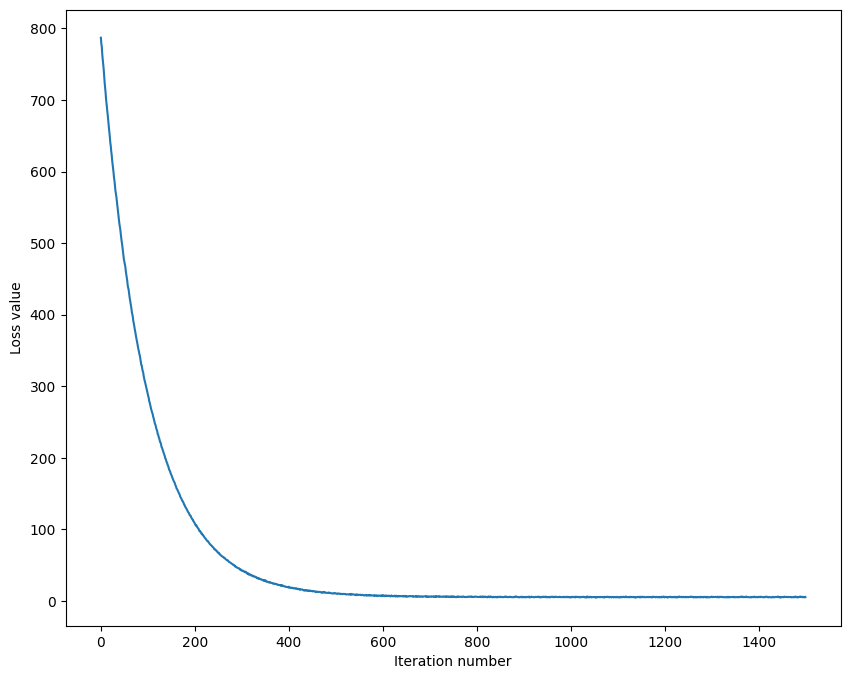

In [32]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [18]:
# 实现 LinearSVM.predict，评测结果
# 由于数据集比较难，在测试集上的正确率大概在35-40%之间
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))

y_test_pred = svm.predict(X_test)
print('test accuracy: %f' % (np.mean(y_test == y_test_pred), ))



training accuracy: 0.369041
test accuracy: 0.371000


In [51]:
# 在验证集上进行超参数调优

X_train_new = X_dev
y_train_new = y_dev

print('New training data shape: ', X_train_new.shape)
print('New training labels shape: ', y_train_new.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

# 1. 定义超参数搜索空间，5*5，具体数值可以修改
learning_rates = [1.5e-7,2e-7,2.5e-7,2.25e-7,2.75e-7]
regularization_strengths = [2.5e4,3e4,1e4,1.5e4,2e4]


New training data shape:  (4000, 3073)
New training labels shape:  (4000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)


In [52]:

# 在验证集上进行超参数调优
best_val_acc = -1
best_params = None
results = {}

print('\n开始超参数调优...')
for lr in learning_rates:
    for reg in regularization_strengths:
        # 创建新的SVM分类器
        svm = LinearSVM()
        
        # 在训练集上训练
        loss_hist = svm.train(X_train_new, y_train_new, 
                             learning_rate=lr, reg=reg,
                             num_iters=400, verbose=False)
        
        # 在验证集上评估
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        
        # 记录结果
        results[(lr, reg)] = val_acc
        
        # 更新最佳参数
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = (lr, reg)
        
        print('lr: %e, reg: %e, val_acc: %f' % (lr, reg, val_acc))

print('\n最佳超参数: learning_rate = %e, reg = %e' % best_params)
print('最佳验证集准确率: %f' % best_val_acc)



开始超参数调优...
lr: 1.500000e-07, reg: 2.500000e+04, val_acc: 0.366000
lr: 1.500000e-07, reg: 3.000000e+04, val_acc: 0.368000
lr: 1.500000e-07, reg: 1.000000e+04, val_acc: 0.314000
lr: 1.500000e-07, reg: 1.500000e+04, val_acc: 0.372000
lr: 1.500000e-07, reg: 2.000000e+04, val_acc: 0.344000
lr: 2.000000e-07, reg: 2.500000e+04, val_acc: 0.366000
lr: 2.000000e-07, reg: 3.000000e+04, val_acc: 0.365000
lr: 2.000000e-07, reg: 1.000000e+04, val_acc: 0.343000
lr: 2.000000e-07, reg: 1.500000e+04, val_acc: 0.351000
lr: 2.000000e-07, reg: 2.000000e+04, val_acc: 0.376000
lr: 2.500000e-07, reg: 2.500000e+04, val_acc: 0.366000
lr: 2.500000e-07, reg: 3.000000e+04, val_acc: 0.340000
lr: 2.500000e-07, reg: 1.000000e+04, val_acc: 0.344000
lr: 2.500000e-07, reg: 1.500000e+04, val_acc: 0.356000
lr: 2.500000e-07, reg: 2.000000e+04, val_acc: 0.361000
lr: 2.250000e-07, reg: 2.500000e+04, val_acc: 0.355000
lr: 2.250000e-07, reg: 3.000000e+04, val_acc: 0.350000
lr: 2.250000e-07, reg: 1.000000e+04, val_acc: 0.34400

best_params
learning_rate: 2e-07
regularization_strength: 20000.0
iteration 0 / 1500: loss 636.427982
iteration 100 / 1500: loss 128.510453
iteration 200 / 1500: loss 29.684451
iteration 300 / 1500: loss 9.673084
iteration 400 / 1500: loss 6.700783
iteration 500 / 1500: loss 5.307767
iteration 600 / 1500: loss 5.135690
iteration 700 / 1500: loss 5.378088
iteration 800 / 1500: loss 5.446874
iteration 900 / 1500: loss 5.279253
iteration 1000 / 1500: loss 4.855727
iteration 1100 / 1500: loss 5.200640
iteration 1200 / 1500: loss 5.401989
iteration 1300 / 1500: loss 5.108554
iteration 1400 / 1500: loss 4.831220

 accuracy on best hyperparams: 0.386000


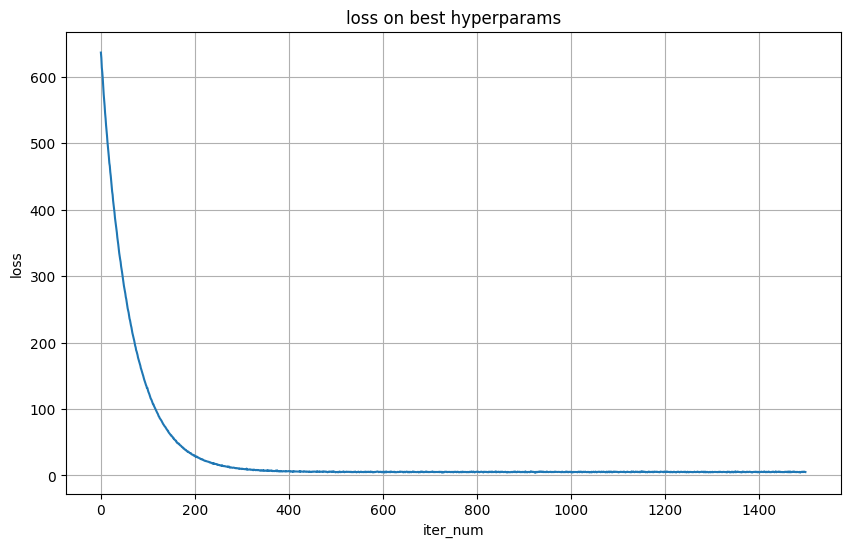

In [56]:

# 使用最佳超参数组合在完整训练集上重新训练
print(f"best_params")
print(f"learning_rate: {best_params[0]}")
print(f"regularization_strength: {best_params[1]}")

best_svm = LinearSVM()
loss_hist_best = best_svm.train(X_train, y_train,
                                learning_rate=best_params[0], 
                                reg=best_params[1],
                                num_iters=1500, verbose=True)

# 5. 在测试集上评估
y_test_pred_best = best_svm.predict(X_test)
test_acc_best = np.mean(y_test == y_test_pred_best)

print('\n accuracy on best hyperparams: %f' % test_acc_best) 

# 可视化损失曲线
plt.figure(figsize=(10, 6))
plt.plot(loss_hist_best)
plt.xlabel('iter_num')
plt.ylabel('loss')
plt.title('loss on best hyperparams')
plt.grid(True)
plt.show()